In [1]:
%pip install mne colorlog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import os
import re
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import utils

logger = utils.get_logger()

# Clustering
When the features have been extracted, there's now a list of files containing one entry per epoch. Each file has a certain paradigm containing: patient, procedure, timing. Clustering can be applied in 3 main ways to find patterns in the data:
1. **Pre/Post procedure**: For each procedure, check if there are any patterns between pre and post procedure epochs (include all patients, all timings, individual procedures) => 3 graphs
2. **cTBS/iTBS/sham**: (all patients, only post, all procedures) => 1 graph

## Initial test

In [ ]:
csv_files = [
    "features_test_1.csv",
    "features_test_2.csv"
]
df = pd.concat((pd.read_csv(f, header=[0, 1]) for f in csv_files))

# outlier removal
# iqr
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1
# df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
# z-score
z_scores = np.abs(stats.zscore(df))
df = df[(z_scores < 3).all(axis=1)]

# normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

# clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(df)

# Plot result with pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df)

plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis')
plt.title("PCA of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

## Test on long list of features

In [24]:
feature_files = os.listdir("features")

# read csv with 2 header rows
dfs = [pd.read_csv(os.path.join("features", file), header=[0, 1]) for file in feature_files if "rsEEG" in file]
df = pd.concat(dfs)
feature_names = df.columns

# outlier removal
def cluster_df(df, n_clusters=2, plot_title="PCA of Clusters"):
    if 'timings' not in df.columns:
        return

    df_ground_truth = df
    df = df.drop(columns=["timings"])
        
    OUTLIER_THRESHOLD = 0.05
    Q1 = df.quantile(0.10)
    Q3 = df.quantile(0.90)
    IQR = Q3 - Q1
    def is_outlier(row):
        return ((row < (Q1 - 1.5 * IQR)) | (row > (Q3 + 1.5 * IQR))).sum()
    outlier_counts = df.apply(is_outlier, axis=1)
    threshold = len(df.columns) * OUTLIER_THRESHOLD
    rows_to_drop = outlier_counts[outlier_counts > threshold].index
    df_filtered = df.drop(index=rows_to_drop)
    print(f"Original DataFrame shape: {df.shape}")
    print(f"Filtered DataFrame shape: {df_filtered.shape}")
    df = df_filtered

    # normalization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df = scaler.fit_transform(df)

    # # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(df)

    # # Evaluate the clustering results
    # score = metrics.adjusted_rand_score(your_labels, clusters)

    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    pca = PCA(n_components=2)
    df_reduced = pca.fit_transform(df)

    plt.subplot(1, 2, 1)
    plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis')
    plt.title(plot_title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label='Cluster Label')

    print(f"lengths: {len(df_reduced[:, 0])}, {len(df_reduced[:, 1])}, {len(df_ground_truth['timings'])}")
    
    plt.subplot(1, 2, 2)
    plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=df_ground_truth["timings"].astype('category').cat.codes, cmap='viridis')
    plt.title("KMeans Clustering Results - Ground Truth")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label='Ground Truth Label')

    plt.show()
    
    # Attributions
    """
    loadings = pca.components_
    for i, component in enumerate(loadings):
        component_loadings = zip(feature_names, component)
        sorted_loadings = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
        print(f"Principal Component {i+1}:")
        for feature, loading in sorted_loadings[:20]:
            print(f"{feature}: {loading}")
        print("\n")
    """
    
cluster_df(df)


In [4]:
labels = utils.get_metadata_df("features", "Randomisatielijst.csv")

In [5]:
labels

,filename,procedure,patient_id,eeg_type,pre_post
0,TMS-EEG-H_02_S1b_spTEP_post-epo.fif.csv,itbs,02,spTEP,post
1,TMS-EEG-H_13_S2_rsEEG_pre-epo.fif.csv,itbs,13,rsEEG,pre
2,TMS-EEG-H_04_S3_spTEP_post-epo.fif.csv,itbs,04,spTEP,post
3,TMS-EEG-H_10_S1_spTEP_pre-epo.fif.csv,sham,10,spTEP,pre
4,TMS-EEG-H_10_S1_rsEEG_post-epo.fif.csv,sham,10,rsEEG,post
...,...,...,...,...,...
172,TMS-EEG-H_09_S2_rsEEG_pre-epo.fif.csv,ctbs,09,rsEEG,pre
173,TMS-EEG-H_06_S3_rsEEG_pre-epo.fif.csv,sham,06,rsEEG,pre
174,TMS-EEG-H_14_S2_rsEEG_post-epo.fif.csv,itbs,14,rsEEG,post
175,TMS-EEG-H_17_S1_rsEEG_pre-epo.fif.csv,itbs,17,rsEEG,pre


[2024-07-11 21:37:56,899] - INFO - Clustering itbs
/tmp/ipykernel_1140/429724327.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=["timings"])


Original DataFrame shape: (586, 744)
Filtered DataFrame shape: (585, 744)
lengths: 585, 585, 586


ValueError: 'c' argument has 586 elements, which is inconsistent with 'x' and 'y' with size 585.

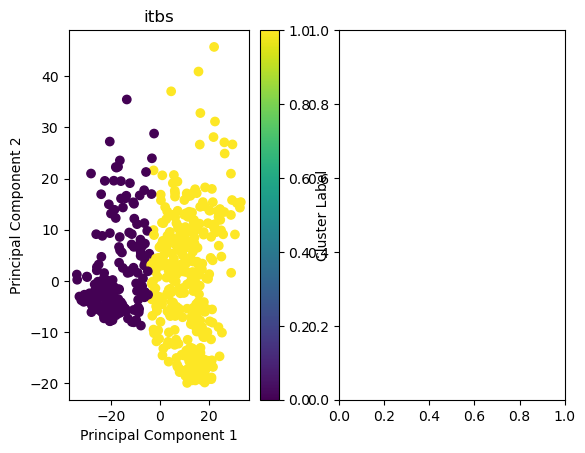

In [25]:
for procedure in ["itbs", "ctbs", "sham"]:
    logger.info(f"Clustering {procedure}")
    for patientid in range(2, 19):
        filenames = labels[(labels["procedure"] == procedure) & (labels["eeg_type"] == "rsEEG") & (labels["patient_id"] == f"{patientid:02}")]["filename"]
        pre_post_values = [labels[labels["filename"] == file]["pre_post"].values[0] for file in filenames]
    
        if len(filenames) == 0:
            continue
        dfs = [pd.read_csv(os.path.join("features", file), header=[0, 1]) for file in filenames]
        df = pd.concat(dfs)
        
        ground_truth = []
        for timing, df_part in zip(pre_post_values, dfs):
            ground_truth.extend([timing] * len(df_part))
        df["timings"] = ground_truth
        #print(df["timings"])
        
        cluster_df(df, plot_title=procedure)

## Clustering: Procedure Impact
The first clustering is done pre/post procedure. The goal is to see if there is a pattern to the impact a procedure has on all patients.
- Patients: all
- Procedures: seperate
- Timing: all
=> 2 or 3 clusters, depending if active control is included

In [ ]:
def cluster_df(df, num_clusters):
    feature_names = df.columns

    # outlier removal
    OUTLIER_THRESHOLD = 0.0
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    def is_outlier(row):
        return ((row < (Q1 - 1.5 * IQR)) | (row > (Q3 + 1.5 * IQR))).sum()
    outlier_counts = df.apply(is_outlier, axis=1)
    threshold = len(df.columns) * OUTLIER_THRESHOLD
    rows_to_drop = outlier_counts[outlier_counts > threshold].index
    df_filtered = df.drop(index=rows_to_drop)
    print(f"Original DataFrame shape: {df.shape}")
    print(f"Filtered DataFrame shape: {df_filtered.shape}")
    df = df_filtered

    # normalization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df = scaler.fit_transform(df)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=2)
    clusters = kmeans.fit_predict(df)

    # PCA
    pca = PCA(n_components=num_clusters)
    df_reduced = pca.fit_transform(df)

    # plot clusters
    plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis')
    plt.title("PCA of Clusters")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label='Cluster Label')
    plt.show()

    # Attributions
    loadings = pca.components_
    for i, component in enumerate(loadings):
        component_loadings = zip(feature_names, component)
        sorted_loadings = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
        print(f"Principal Component {i+1}:")
        for feature, loading in sorted_loadings[:20]:
            print(f"{feature}: {loading}")
        print("\n")

In [ ]:
def get_procedure_df(procedure_id):
    dfs = []
    label_df = pd.read_csv("labels.csv")
    for filename in os.listdir("features"):
        filename = filename.split(".")[0]
        # get row from label_df with matching filename
        row = label_df[label_df["filename"] == filename]
        if(row["procedure"].values[0] == procedure_id):
            df = pd.read_csv(os.path.join("features", filename + ".csv"), header=[0, 1])
            dfs.append(df)
    if len(dfs) == 0:
        return None
    df = pd.concat(dfs)
    return df

### cTBS

In [ ]:
ctbs_df = get_procedure_df(2)

In [ ]:
cluster_df(ctbs_df, 2)

### iTBS

In [ ]:
df = get_procedure_df(1)